# Arima 
Fundamental Intuation behid time seriese forecasting is that meaure of target variable at a point depends on measure of the target variable at a previous point in time. (2,3,4... time periods prior).

__Auto-Correlation__: Consider both direct and indirect effects. 


__Partial Auto-Correlation__: Considers only the direct effect like figure below


https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/


In [7]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

In [8]:
# df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')
df = pd.read_pickle('../dataset/preprocessed/1479_imputed.pkl')

In [9]:
df = df[df['LeadTime']==0]
df = df.rename(columns={'Reservations':'ROH'})
df = df.drop(columns=['LeadTime','DOW','Price','TotalCapacity'])
df = df.set_index('DOA')
df = df.asfreq(freq='d', method='ffill')
train = df[:'2019-09-30']
test  = df['2019-09-30':]

In [4]:
# removing one anomilie 
df.loc[df.ROH<150.0, 'ROH'] = df['ROH'].median()

In [10]:
df.describe().transpose()

count        mean        std   min    25%    50%    75%    max
ROH  730.0  191.689041  43.232241  11.0  175.0  212.0  221.0  226.0

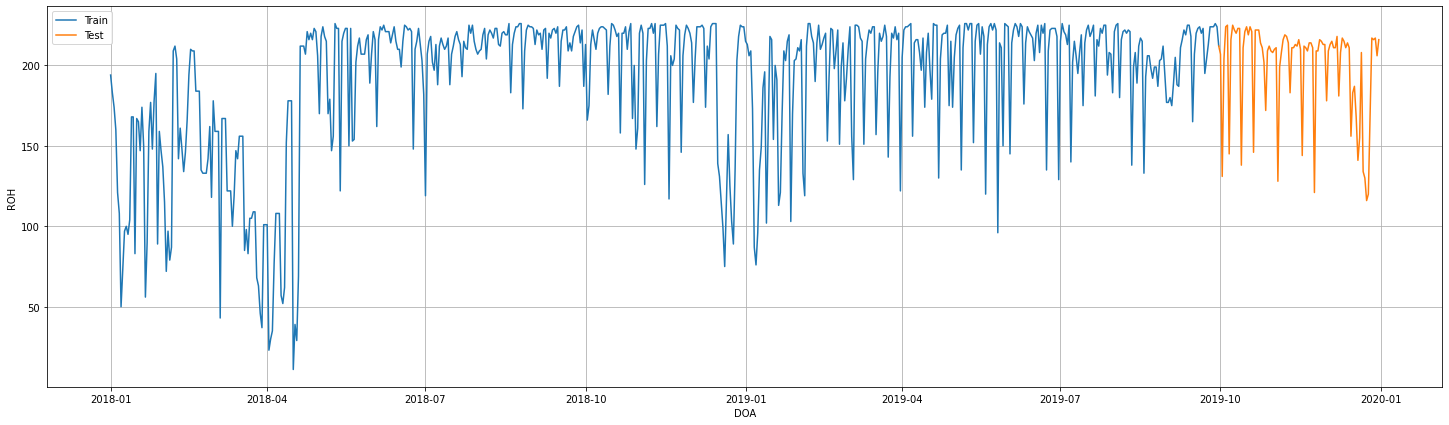

In [11]:
plt.figure(figsize=(25,7))
plt.plot(train.index, train['ROH'], label='Train')
plt.plot(test.index, test['ROH'], label='Test')
plt.xlabel('DOA')
plt.ylabel('ROH')
plt.legend(loc='best')
plt.show()

<Figure size 1800x504 with 0 Axes>

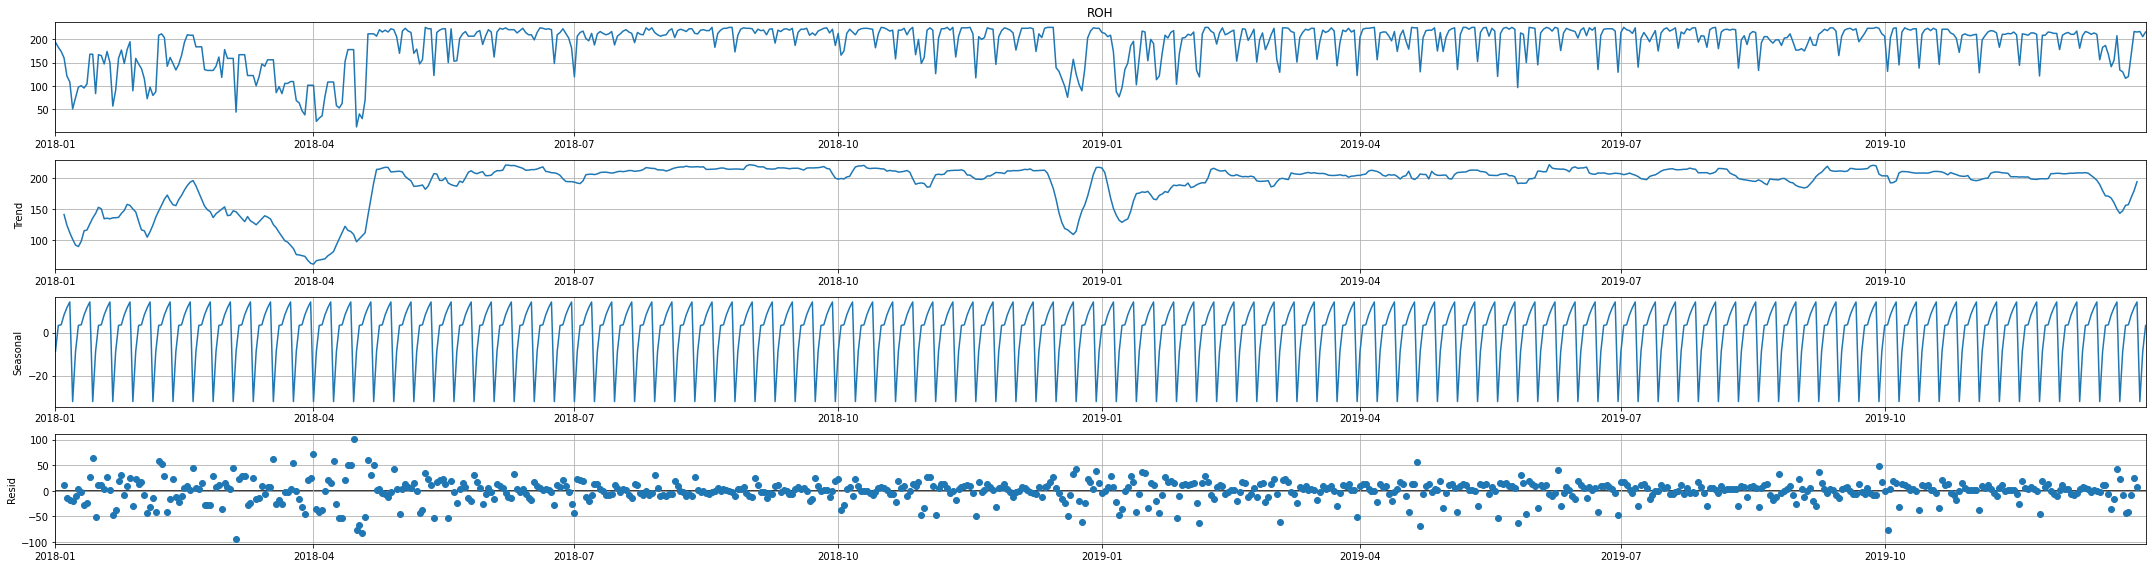

In [6]:
plt.figure(figsize=(25,7))
sm.tsa.seasonal_decompose(df.ROH).plot()
result = sm.tsa.stattools.adfuller(df.ROH)
plt.show()

Check if time serise is stationary:
- You need differencing only if series is non-stationary. You can check that if the P Value > 0.05 we go ahead with finding the order of differencing. 
- Else, no differencing is needed, that is, d=0.

In [8]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train.ROH.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Test: ' ,result[1]>0.05)

ADF Statistic: -3.091354
p-value: 0.027200
Test:  False


In our case the differencing is needed since 0.001447>0.05.

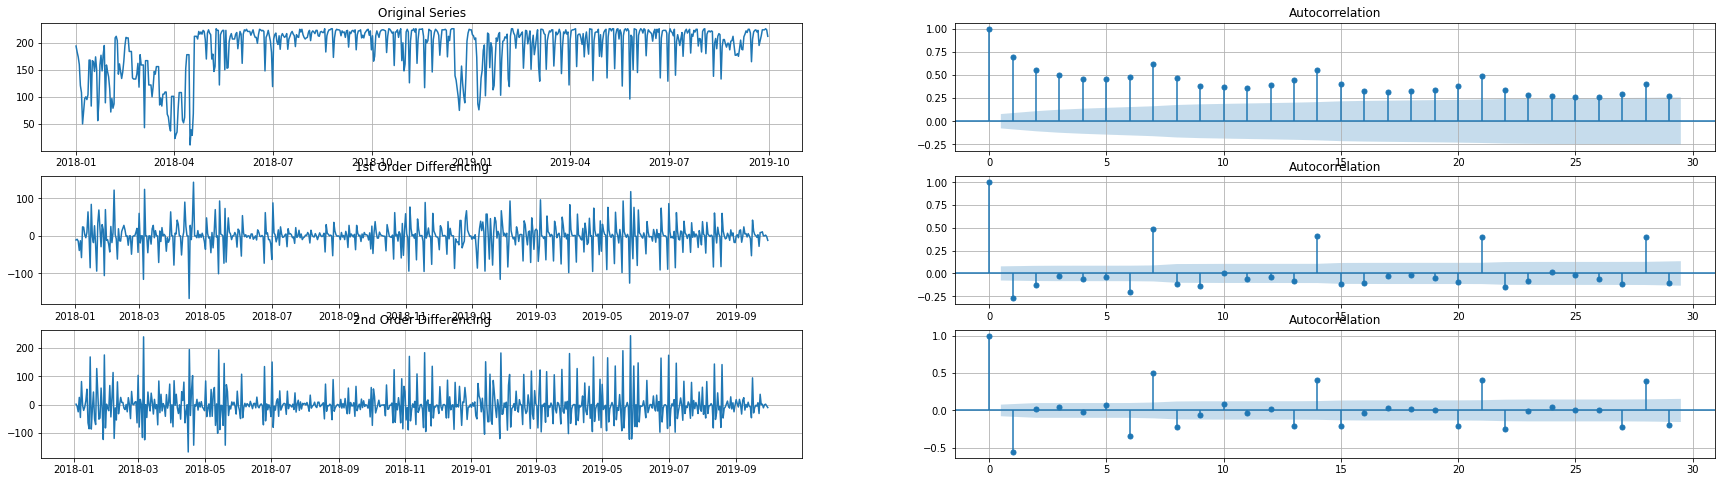

In [9]:
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(train.ROH) 
axes[0, 0].set_title('Original Series')
plot_acf(train.ROH, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.ROH.diff()) 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.ROH.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.ROH.diff().diff()) 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.ROH.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [73]:
y = train.ROH

## Adf Test
print(ndiffs(y, test='adf'))  # 2

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
print(ndiffs(y, test='pp'))  # 2

0
1
0


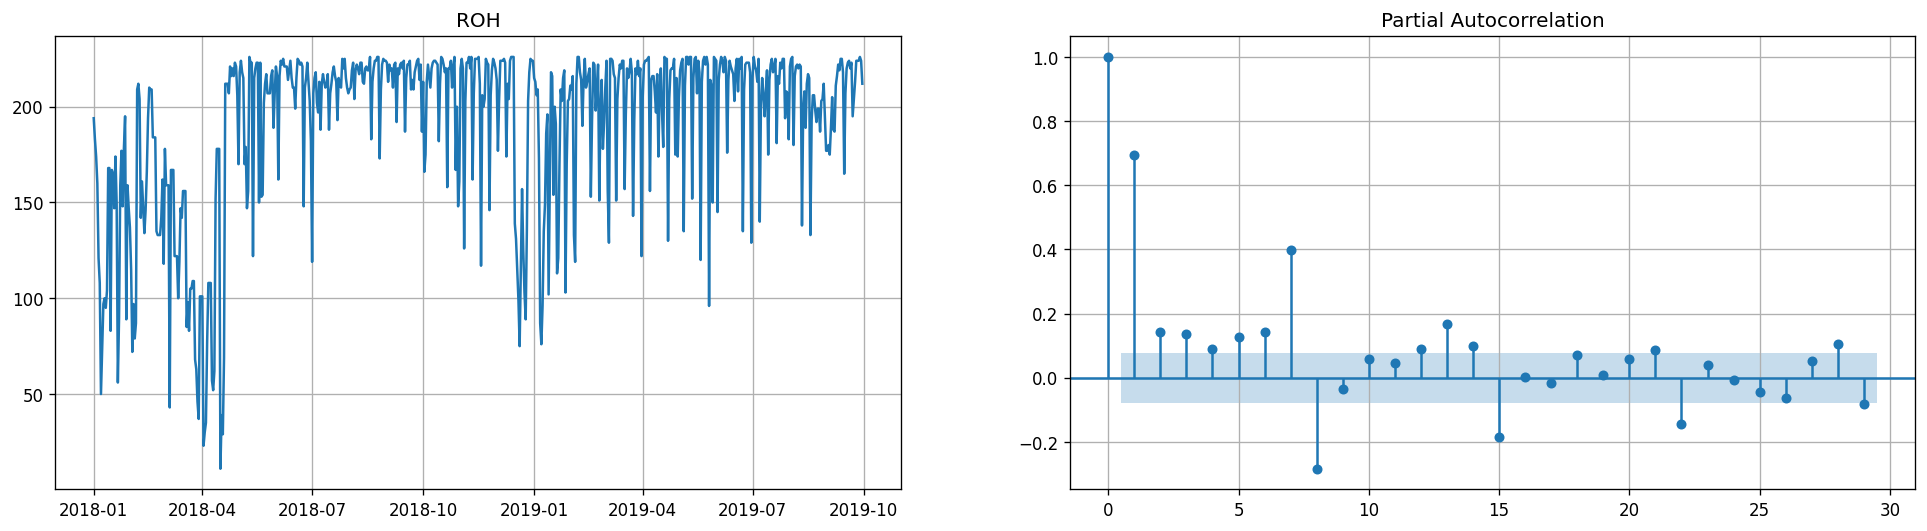

In [10]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(train.ROH)
axes[0].set_title('ROH')
plot_pacf(train.ROH.dropna(), ax=axes[1])
plt.show()

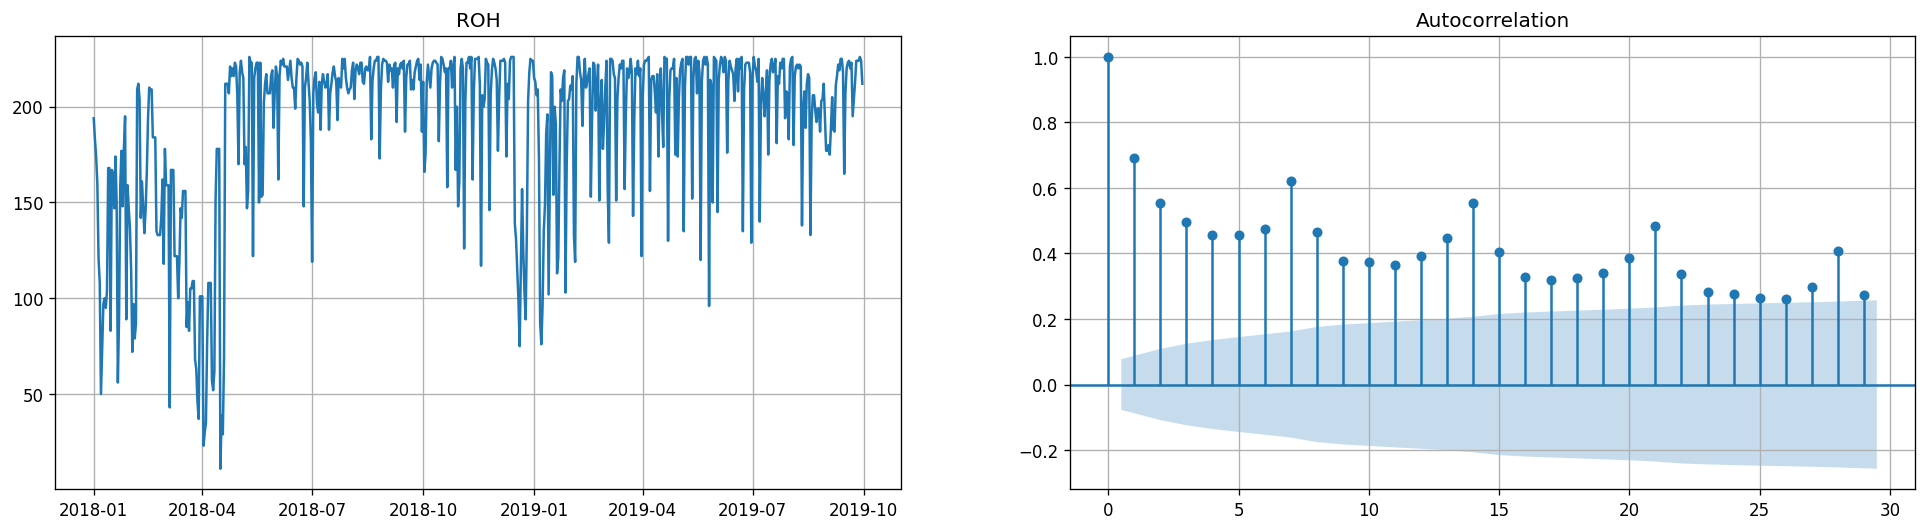

In [11]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(train.ROH)
axes[0].set_title('ROH')
plot_acf(train.ROH.dropna(), ax=axes[1])

plt.show()

In [12]:
# 1,1,2 ARIMA Model
model = ARIMA(train.ROH, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  637
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3085.457
Method:                       css-mle   S.D. of innovations             30.692
Date:                Mon, 30 Nov 2020   AIC                           6180.914
Time:                        09:59:23   BIC                           6203.198
Sample:                    01-02-2018   HQIC                          6189.565
                         - 09-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1186      0.200      0.594      0.552      -0.273       0.510
ar.L1.D.ROH     0.3121      0.118      2.643      0.008       0.081       0.544
ma.L1.D.ROH    -0.8094      0.121     -6.697    

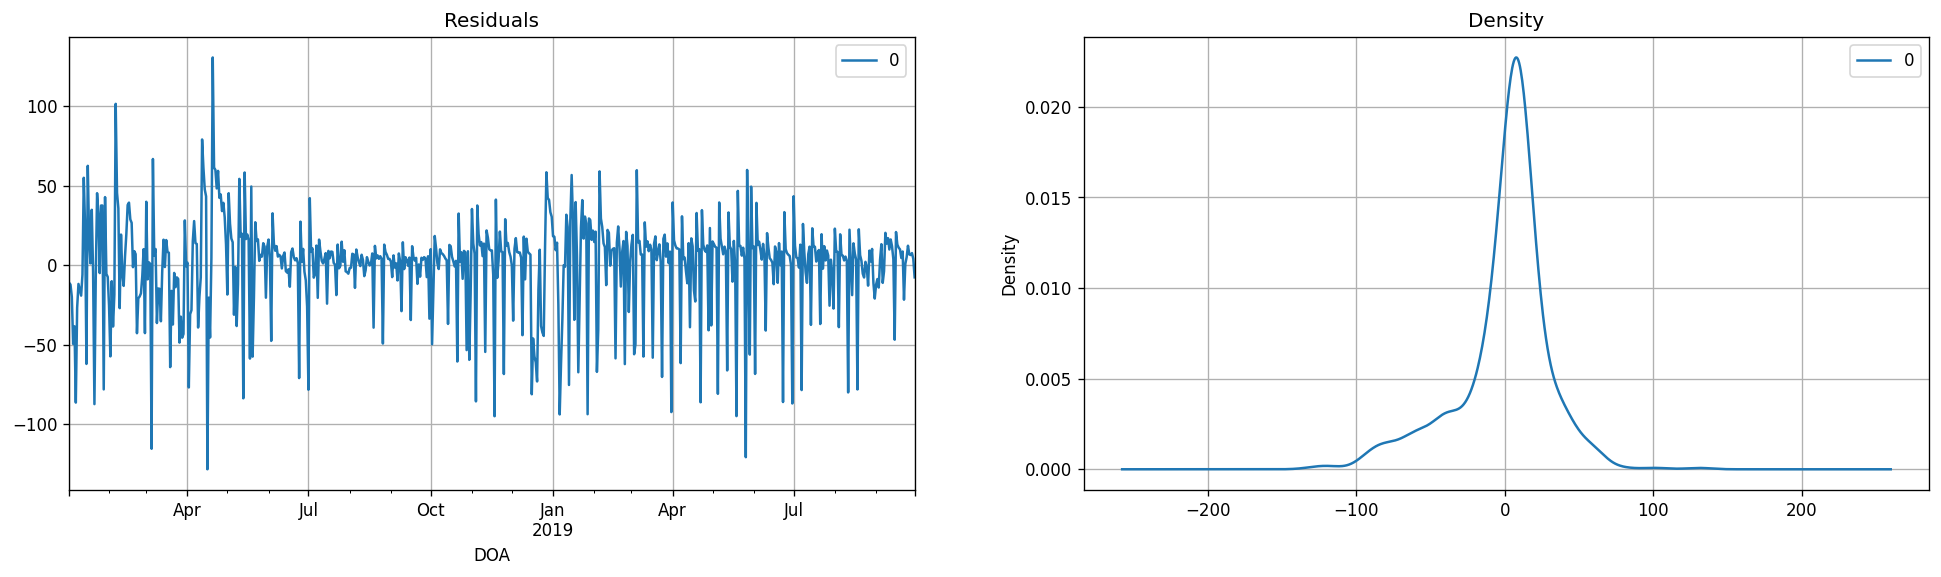

In [13]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

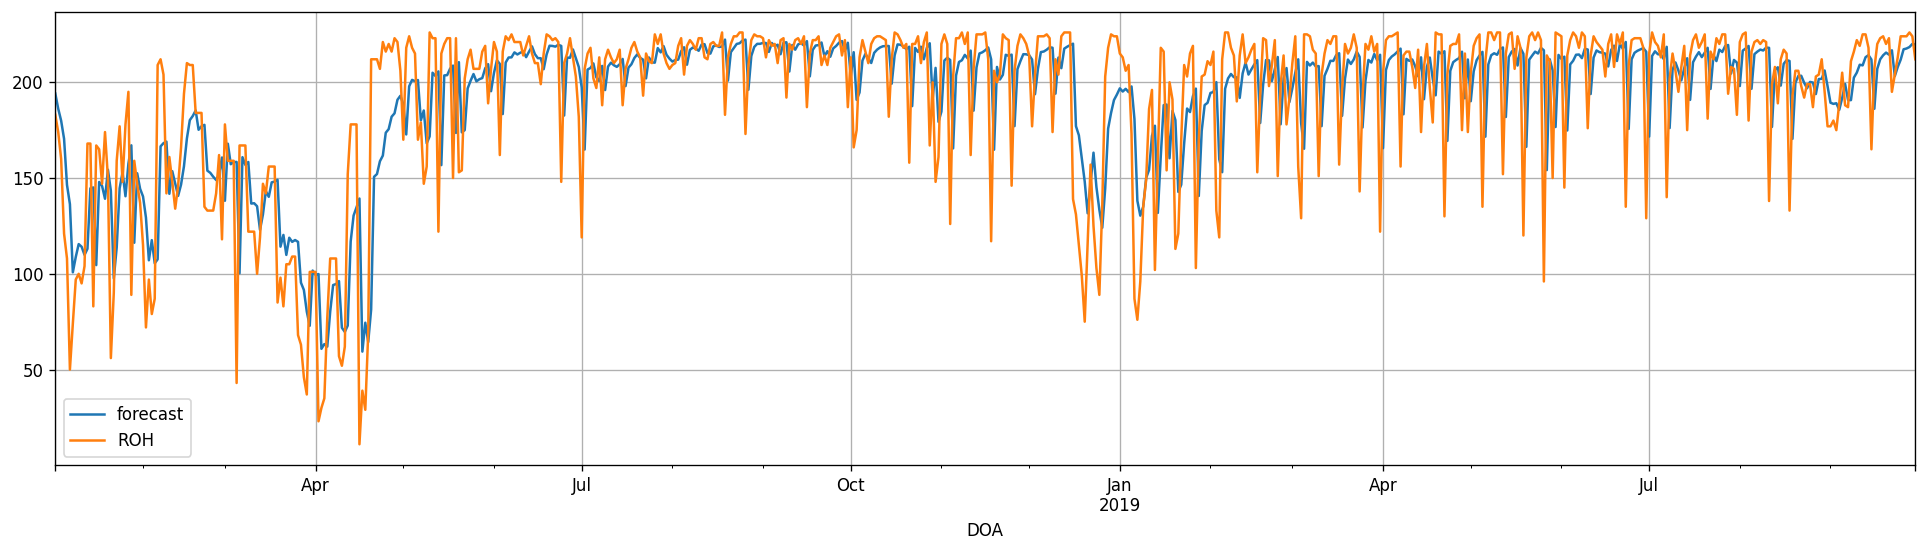

In [14]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

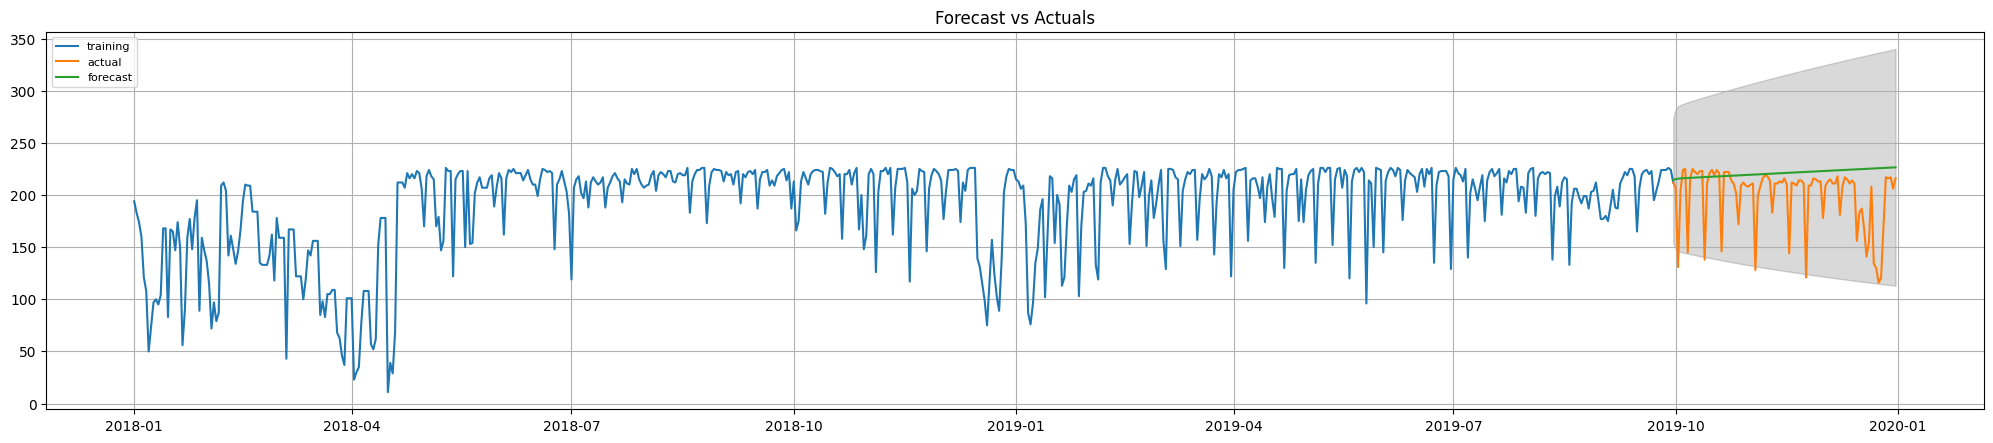

In [15]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(93, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(25,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [16]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # corr = np.corrcoef(forecast, actual)[0,1]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse}) #, 'acf1':acf1, 'corr':corr, 'minmax':minmax

forecast_accuracy(fc, test.values)

{'mape': 0.14610789506835564,
 'me': 21.856862839043806,
 'mae': 22.640704201664587,
 'mpe': 0.14259230411657042,
 'rmse': 36.700924310604904}

In [17]:
model = pm.auto_arima(train.ROH, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6252.701, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.182, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6352.961, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7803.239, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6193.106, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6194.311, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6194.417, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6197.737, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6191.691, Time=0.52 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=6183.905, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6192.770, Time=0.38 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=6176.052, Time=0.77 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6

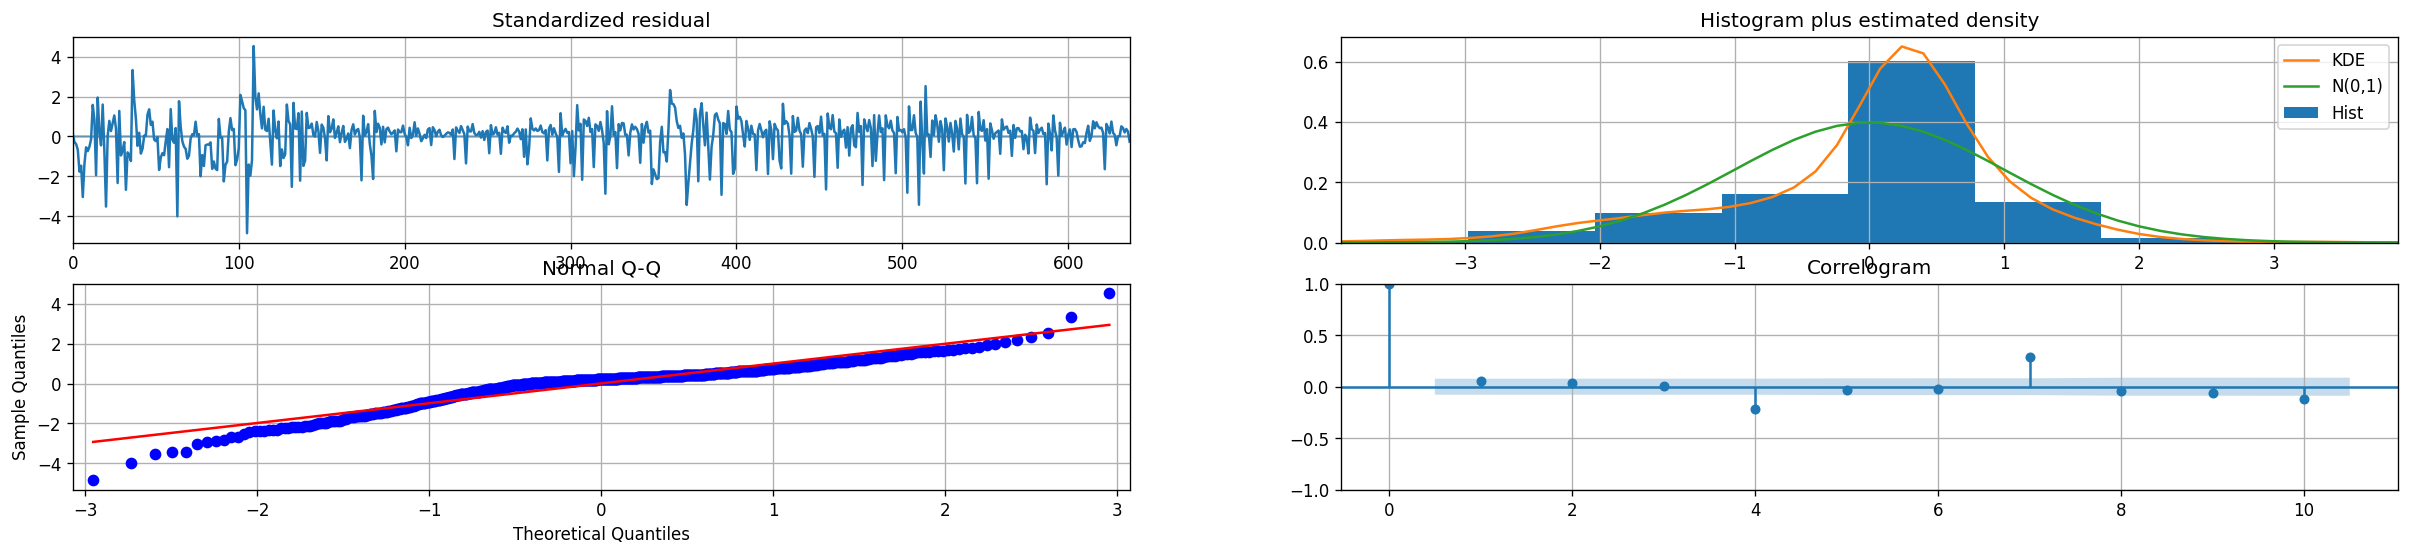

In [18]:
model.plot_diagnostics(figsize=(25,5))
plt.show()

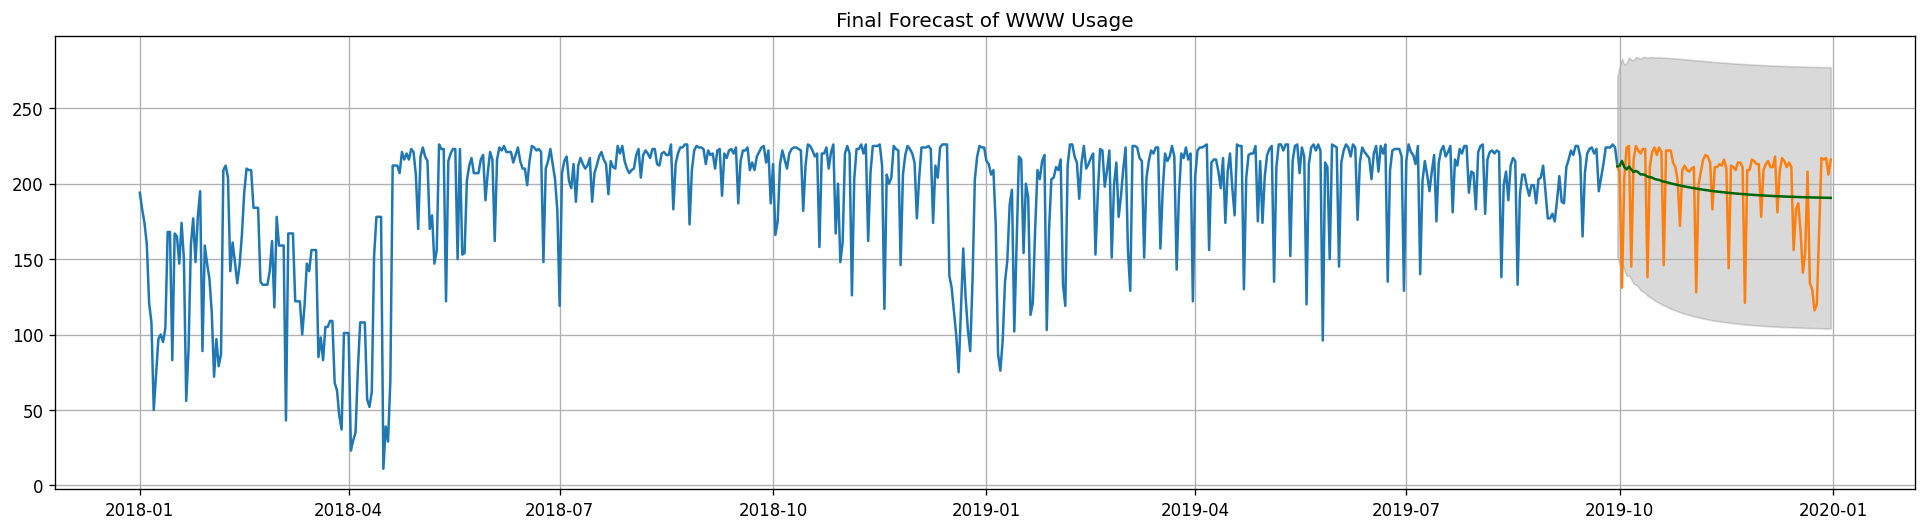

In [19]:
# Forecast
n_periods = 93
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = test.index #np.arange(len(train.ROH), len(train.ROH)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train.ROH)
plt.plot(test)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [20]:
forecast_accuracy(fc_series.values,test.values)

{'mape': 0.14036289329190643,
 'me': -2.4355541080511847,
 'mae': 24.167881478651395,
 'mpe': 0.017026698976183616,
 'rmse': 30.081017322530773}

# SARIMA

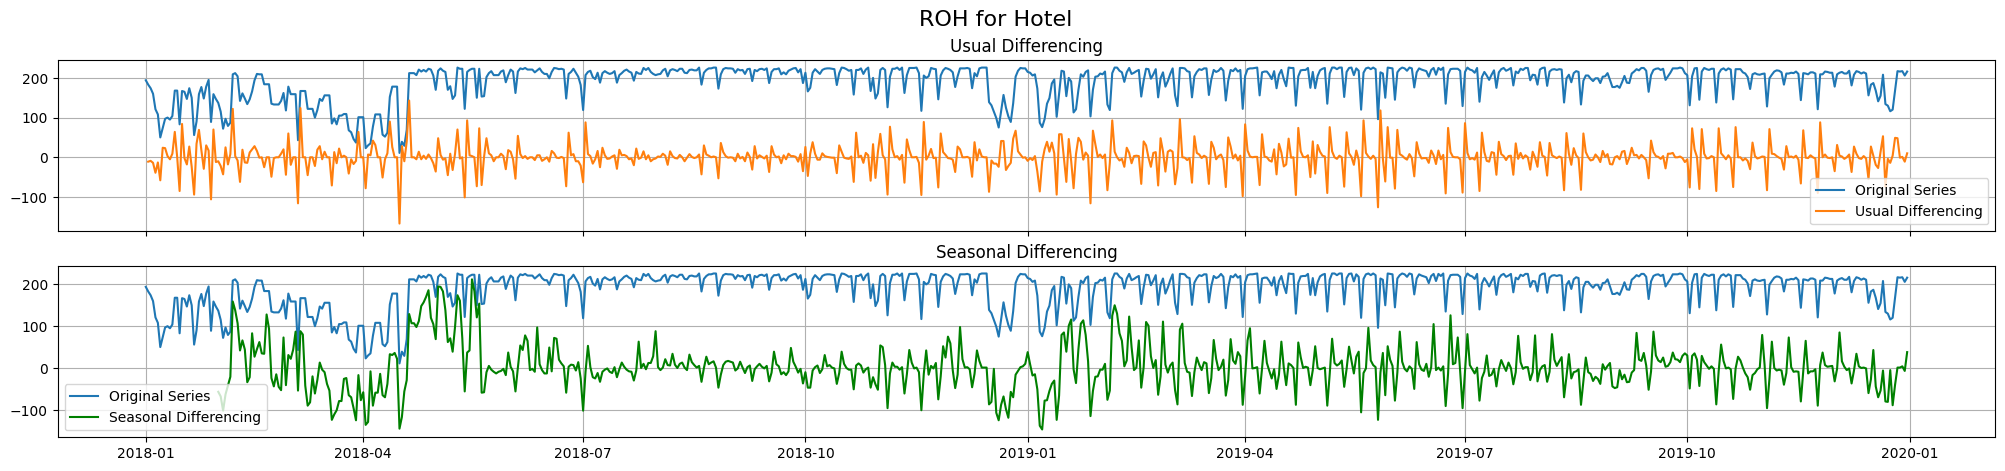

In [21]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(25,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Original Series')
axes[0].plot(df[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='best', fontsize=10)


# Seasinal Dei
axes[1].plot(df[:], label='Original Series')
axes[1].plot(df[:].diff(30), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='best', fontsize=10)
plt.suptitle('ROH for Hotel', fontsize=16)
plt.show()

In [22]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=6229.944, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6664.492, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6250.932, Time=0.56 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6354.065, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8546.182, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=6228.654, Time=0.25 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=6230.619, Time=1.47 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=6399.450, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6249.962, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=6191.933, Time=0.46 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=6235.158, Time=1.83 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6198.542, Time=1.45 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=6249.117, Time=1.66 sec
 ARIMA(2,0,0)(0,0,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  638
Model:             SARIMAX(3, 0, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -3067.370
Date:                                 Mon, 30 Nov 2020   AIC                           6154.740
Time:                                         10:01:43   BIC                           6199.323
Sample:                                              0   HQIC                          6172.047
                                                 - 638                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.1676      7.133      3.528      0.000      11.187      39.148
ar.L1          0.4974      0.020     24.705      0.000       0.458       0.537
ar.L2         -0.5617      0.013    -43.183      0.000      -0.587      -0.536
ar.L3          0.9308      0.020     46.277      0.000       0.891       0.970
ma.L1          0.0393      0.035      1.138      0.255      -0.028       0.107
ma.L2          0.7254      0.028     26.115      0.000       0.671       0.780
ma.L3         -0.4042      0.040    -10.094      0.000      -0.483      -0.326
ma.S.L12       0.0943      0.048      1.966      0.049       0.000       0.188
ma.S.L24      -0.1559      0.037     -4.245      0.000      -0.228      -0.084
sigma2       824.0713     34.313     24.017      0.000     756.820     891.323
===================================================================================
Ljung-Box (Q):                      430.78   Jarque-Bera (JB):               348.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

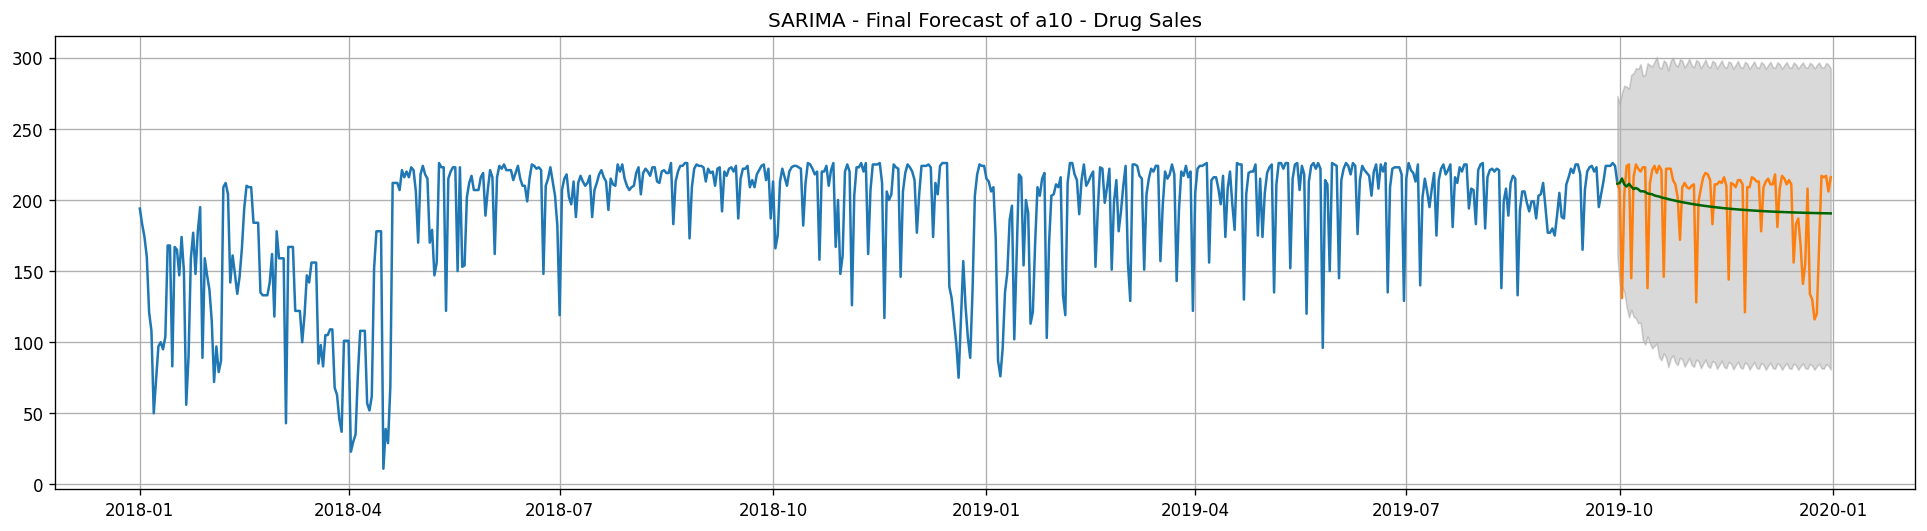

In [23]:
# Forecast
n_periods = 93
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = test.index #np.arange(len(train.ROH), len(train.ROH)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train.ROH)
plt.plot(test)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

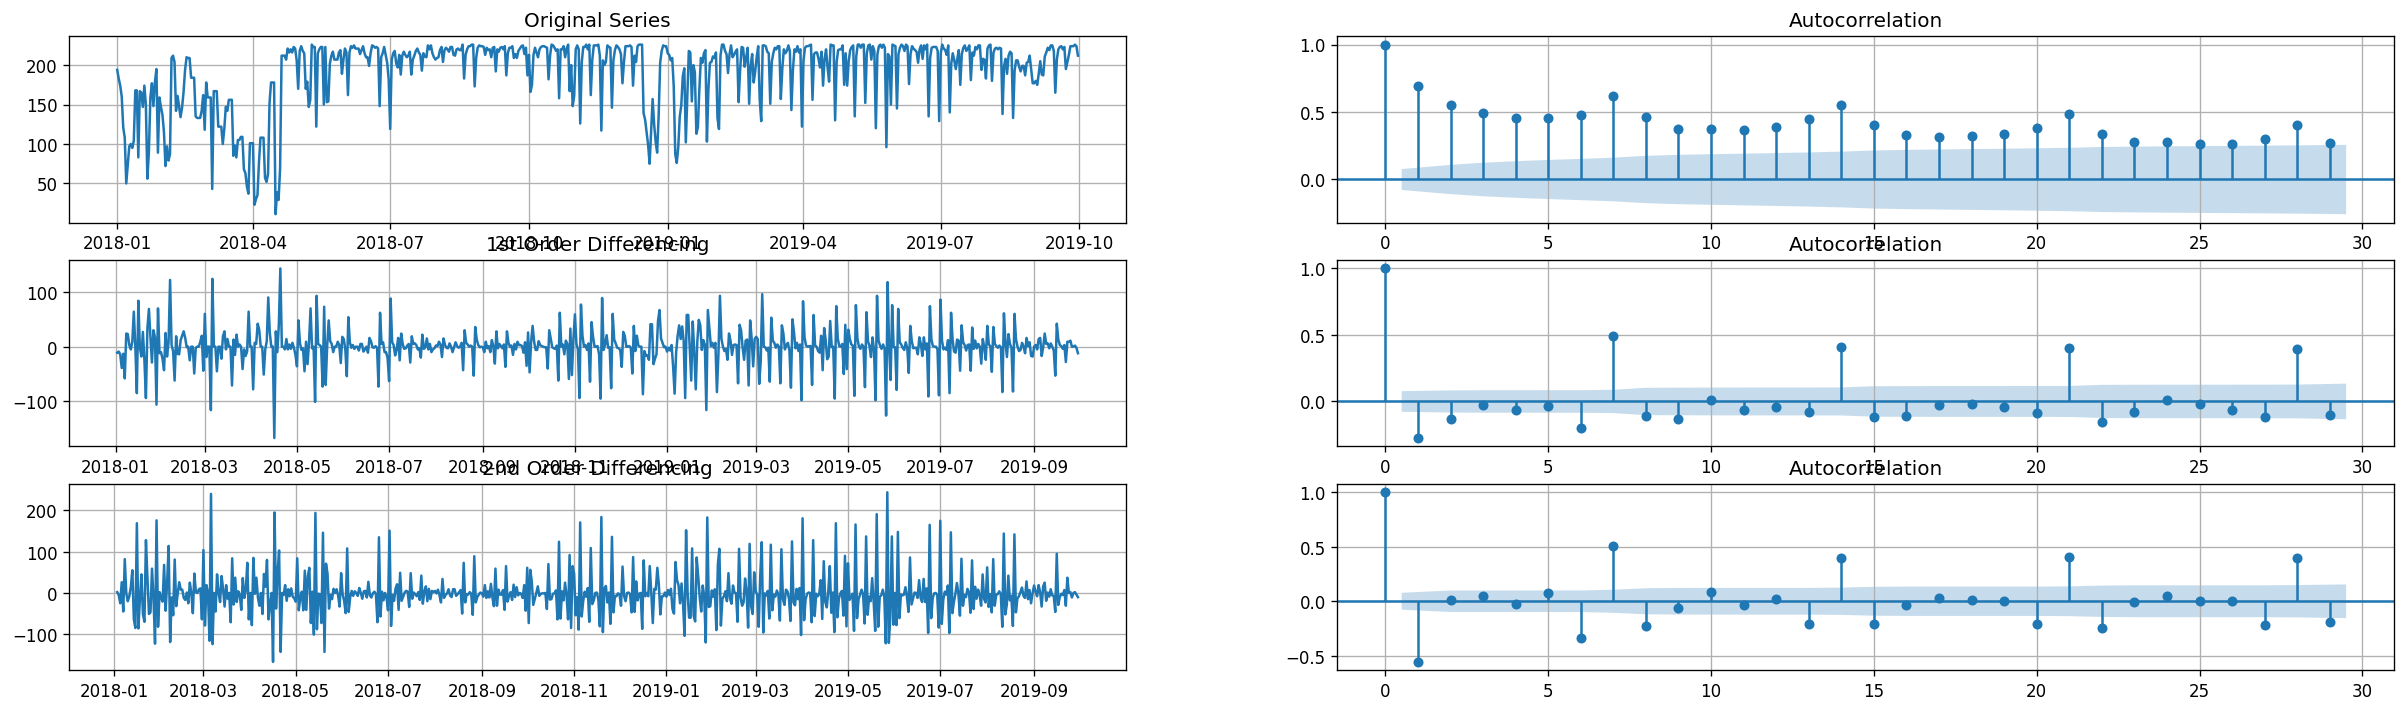

In [24]:
plt.rcParams.update({'figure.figsize':(25,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(train.ROH); axes[0, 0].set_title('Original Series')
plot_acf(train.ROH, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.ROH.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.ROH.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.ROH.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.ROH.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [89]:
y = train.ROH

## Adf Test
print(ndiffs(y, test='adf'))  # 0

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
print(ndiffs(y, test='pp'))  # 0

0
1
0


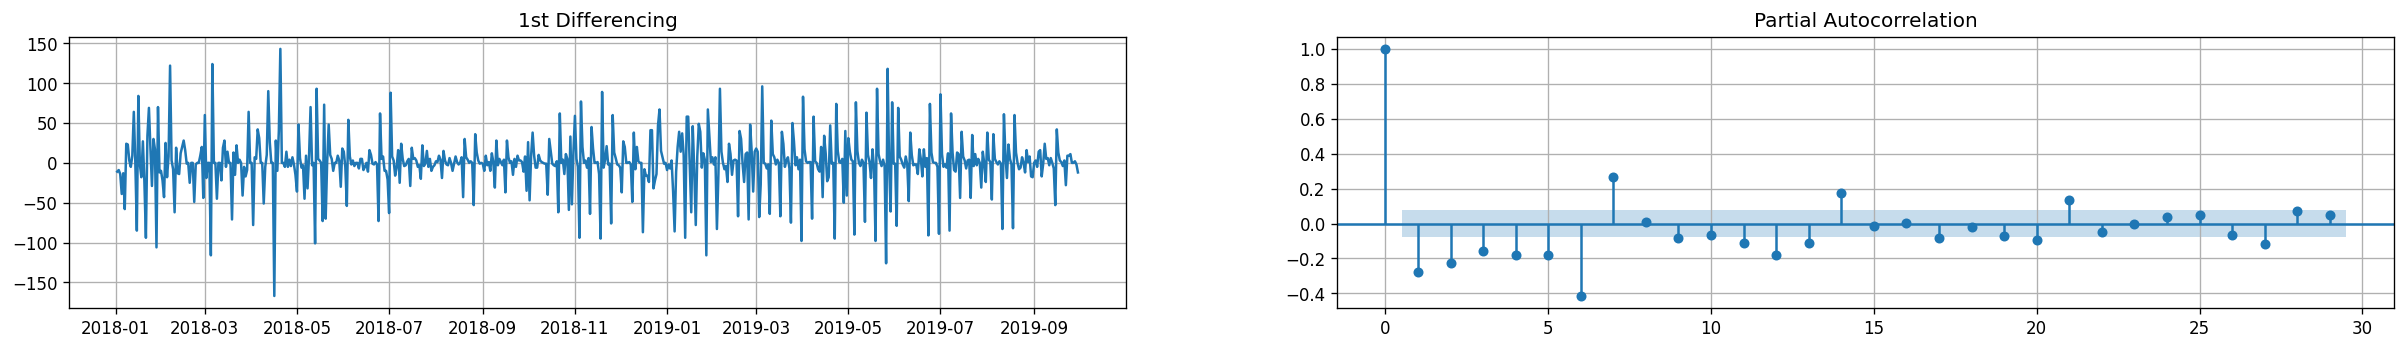

In [25]:
plt.rcParams.update({'figure.figsize':(25,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(train.ROH.diff()); axes[0].set_title('1st Differencing')
plot_pacf(train.ROH.diff().dropna(), ax=axes[1])

plt.show()

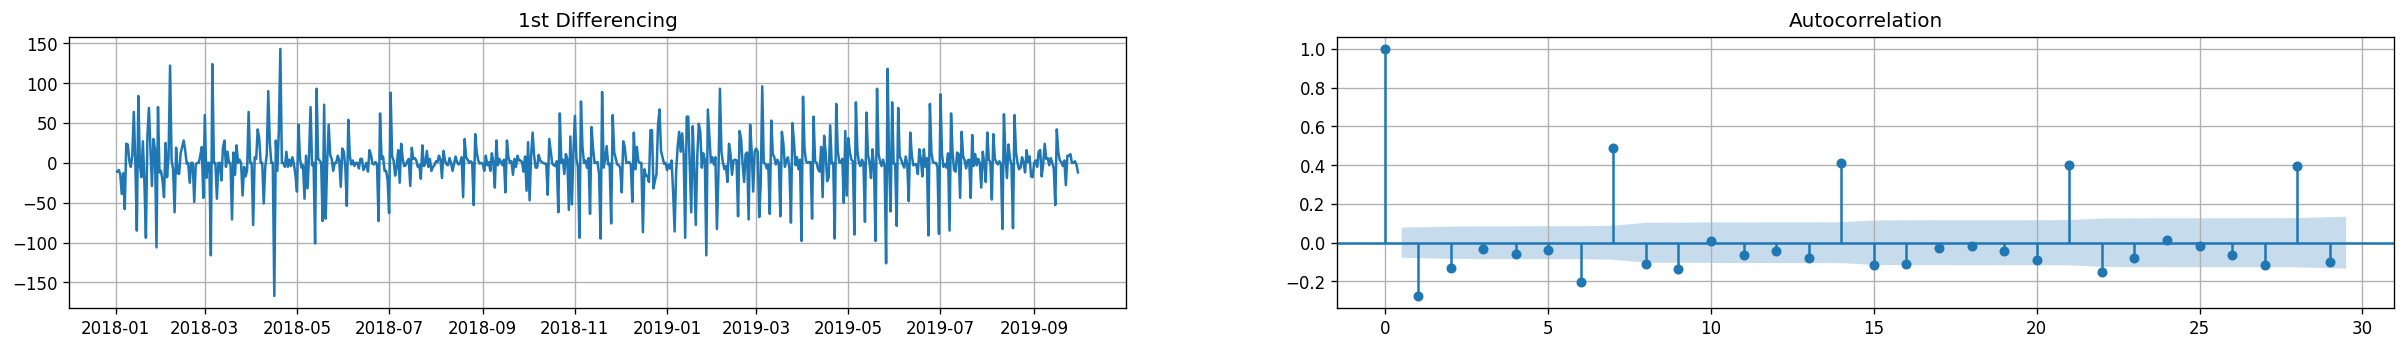

In [26]:
plt.rcParams.update({'figure.figsize':(25,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(train.ROH.diff()); axes[0].set_title('1st Differencing')
plot_acf(train.ROH.diff().dropna(), ax=axes[1])

plt.show()

In [27]:
model = ARIMA(train.ROH, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  637
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3085.457
Method:                       css-mle   S.D. of innovations             30.692
Date:                Mon, 30 Nov 2020   AIC                           6180.914
Time:                        10:02:09   BIC                           6203.198
Sample:                    01-02-2018   HQIC                          6189.565
                         - 09-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1186      0.200      0.594      0.552      -0.273       0.510
ar.L1.D.ROH     0.3121      0.118      2.643      0.008       0.081       0.544
ma.L1.D.ROH    -0.8094      0.121     -6.697    

In [28]:
model = ARIMA(train.ROH, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  637
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3085.796
Method:                       css-mle   S.D. of innovations             30.709
Date:                Mon, 30 Nov 2020   AIC                           6179.591
Time:                        10:02:09   BIC                           6197.419
Sample:                    01-02-2018   HQIC                          6186.512
                         - 09-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1183      0.193      0.613      0.540      -0.260       0.497
ar.L1.D.ROH     0.3974      0.047      8.509      0.000       0.306       0.489
ma.L1.D.ROH    -0.9057      0.022    -40.524    

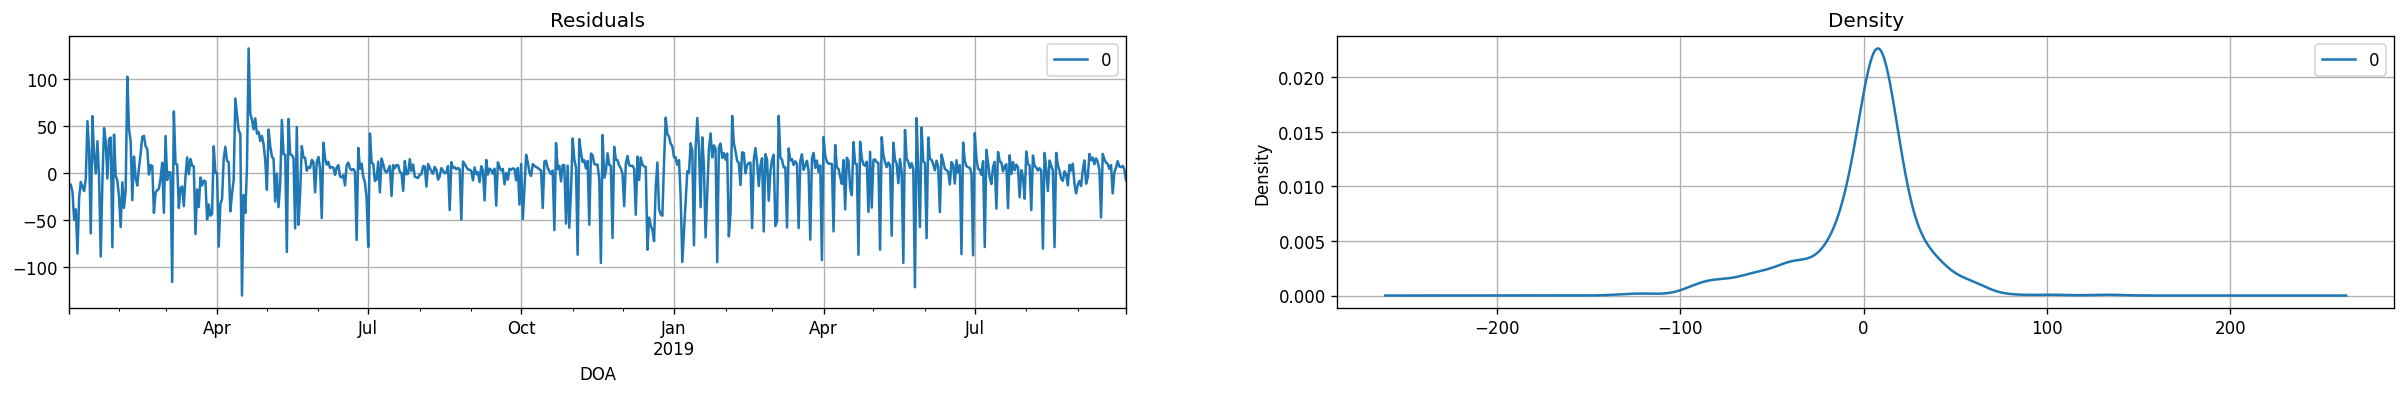

In [29]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

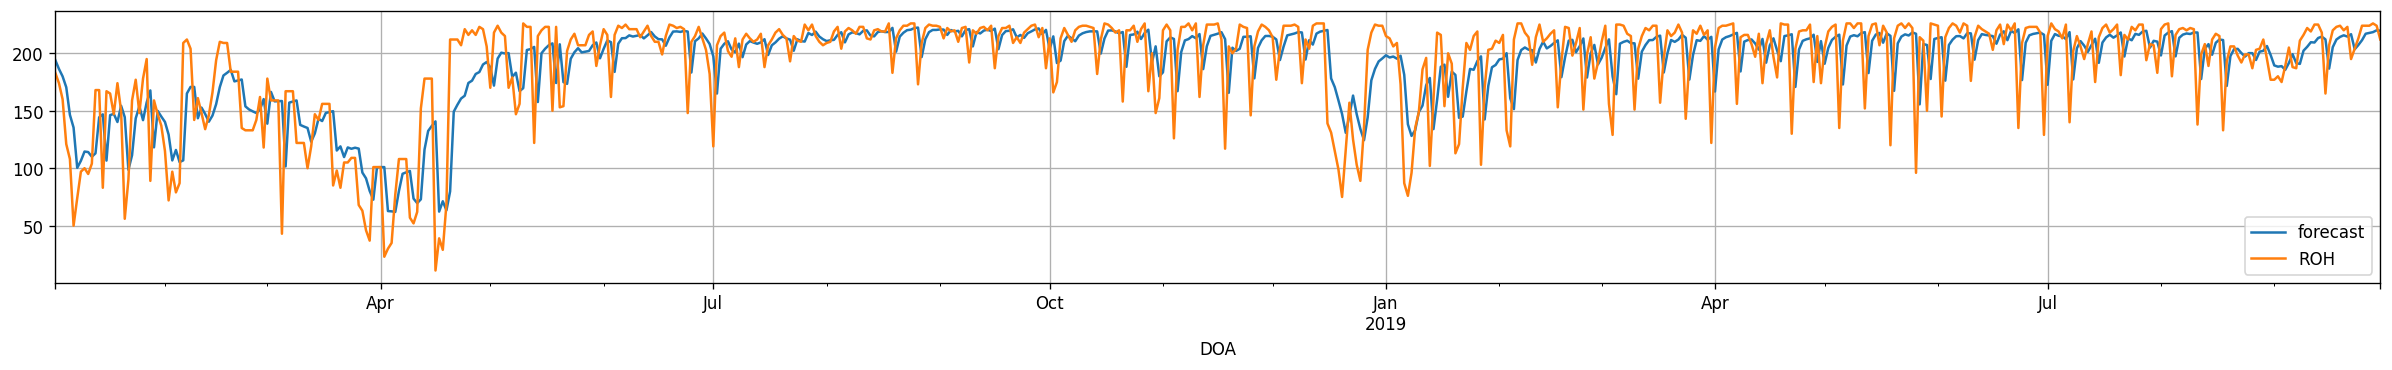

In [30]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

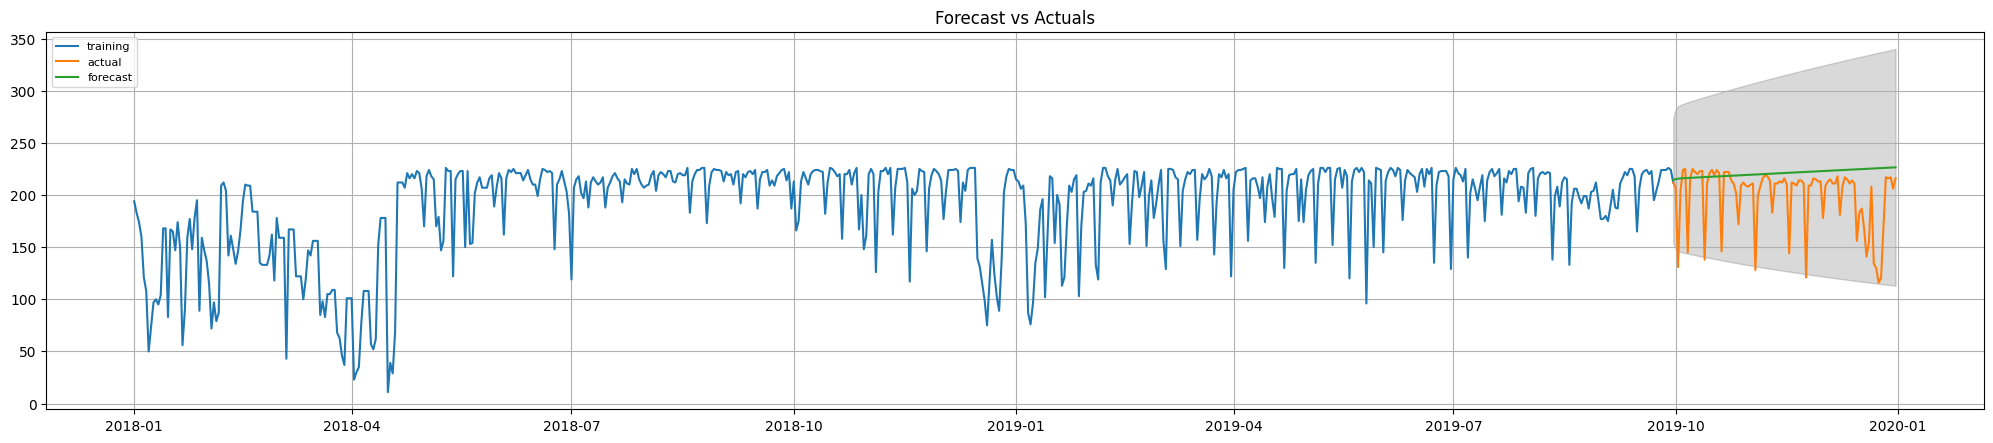

In [31]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(93, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(25,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  637
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2796.828
Method:                       css-mle   S.D. of innovations                nan
Date:                Mon, 23 Nov 2020   AIC                           5609.655
Time:                        18:18:14   BIC                           5645.309
Sample:                    01-02-2018

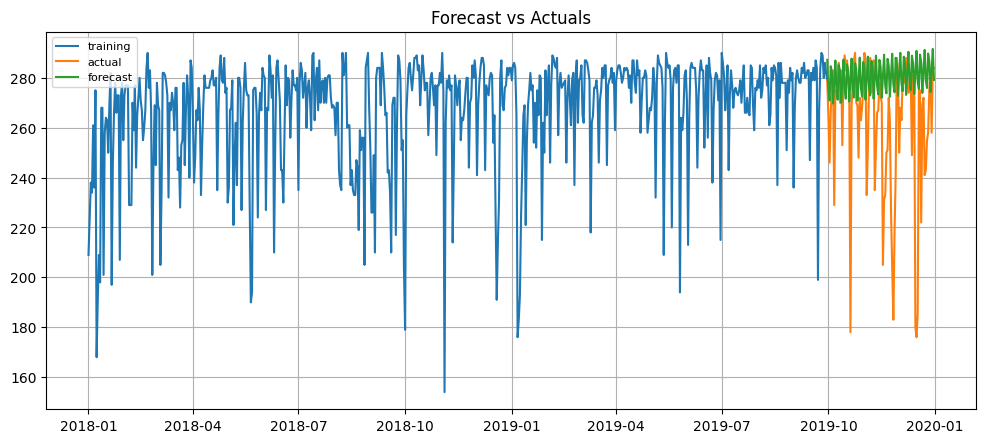

In [97]:
# Build Model
model = ARIMA(train, order=(3, 1, 3))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(93, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [98]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # corr = np.corrcoef(forecast, actual)[0,93]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse}) #, 'acf1':acf1, 'corr':corr, 'minmax':minmax

forecast_accuracy(fc, test.values)

{'mape': 0.09834261770903395,
 'me': 18.687840624176424,
 'mae': 22.19666282474505,
 'mpe': 0.08601909432892324,
 'rmse': 33.82720676781702}

In [99]:
model = pm.auto_arima(df.ROH, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6610.125, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10234.119, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9313.551, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6530.637, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6530.880, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6531.220, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6533.976, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6531.980, Time=0.10 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 2.039 seconds
                               SARIMAX Results                                
Dep. Variable:              

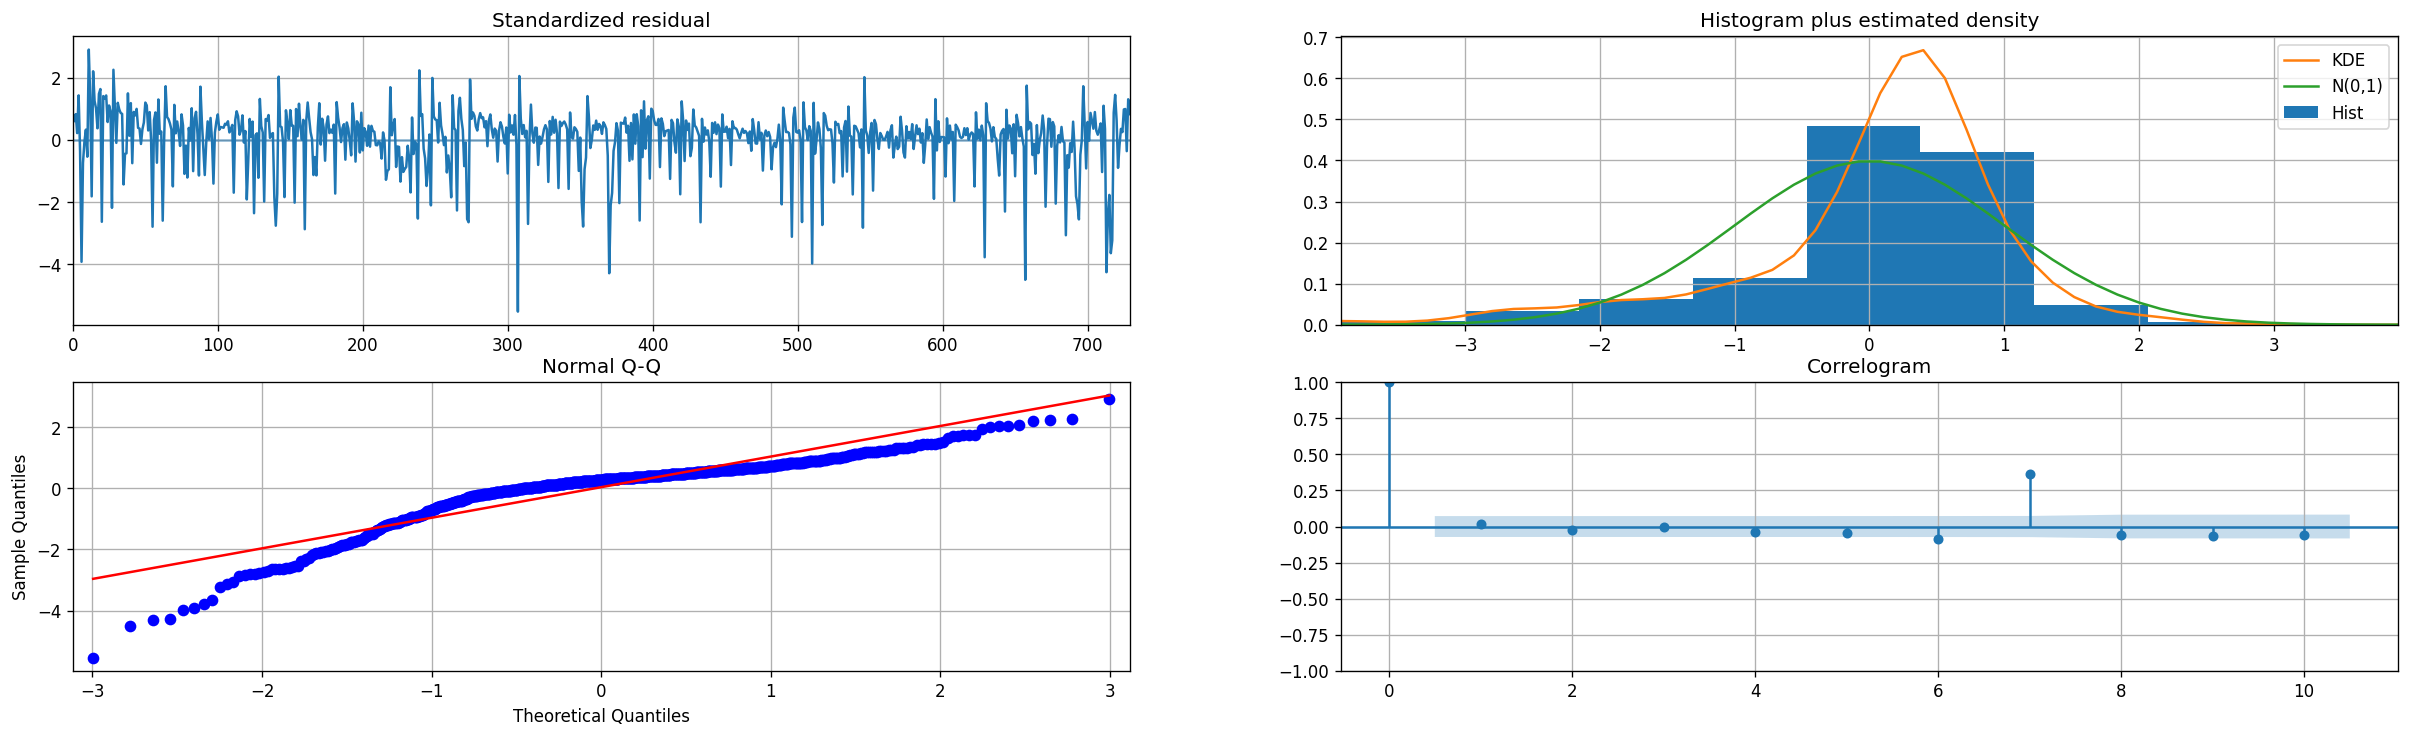

In [38]:
model.plot_diagnostics(figsize=(25,7))
plt.show()

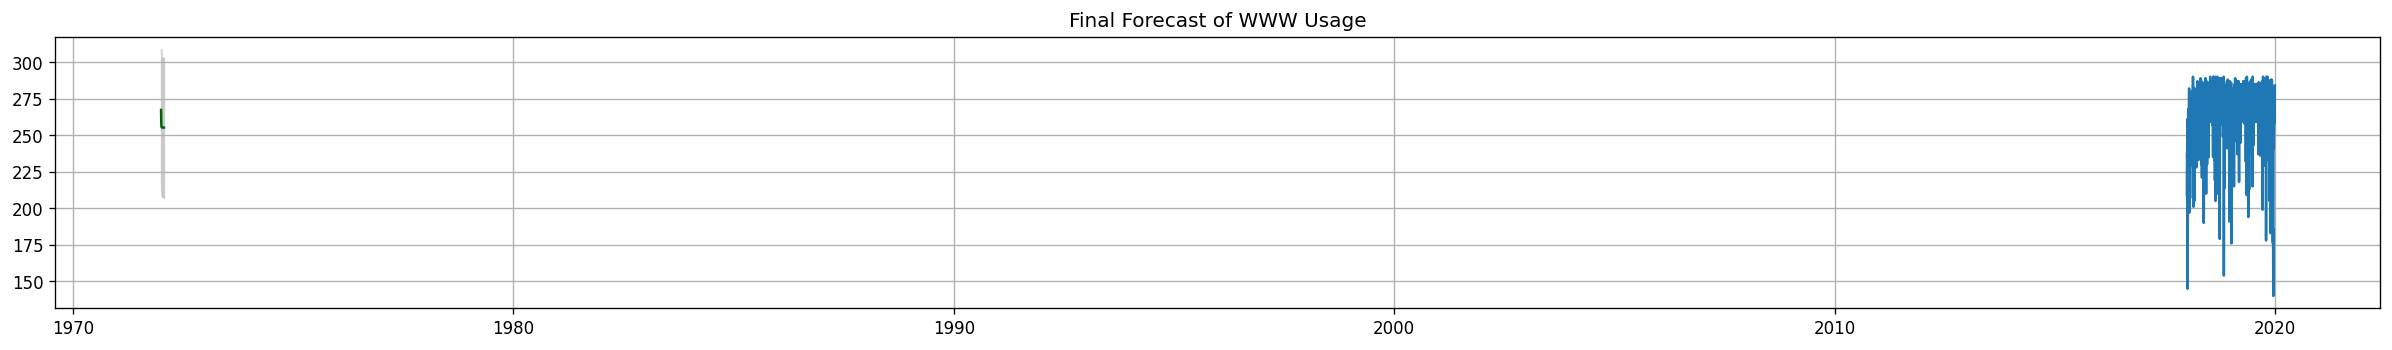

In [39]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.ROH), len(df.ROH)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.ROH)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

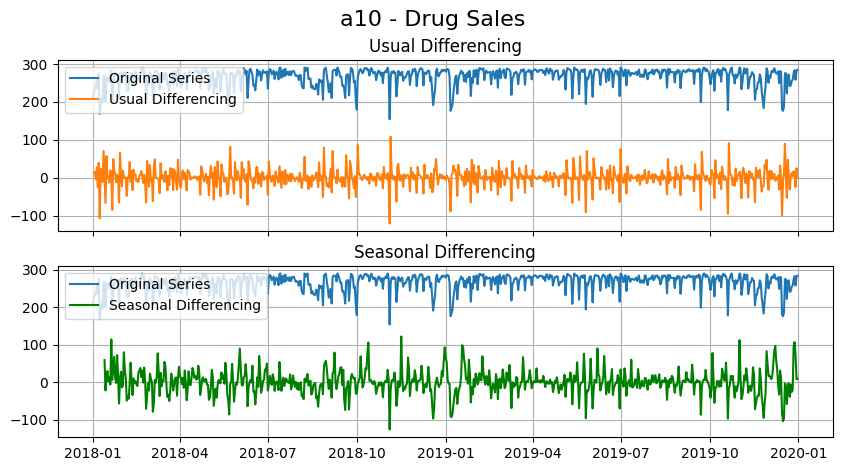

In [100]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Original Series')
axes[0].plot(df[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df[:], label='Original Series')
axes[1].plot(df[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [41]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=6069.905, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5829.443, Time=1.00 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=6068.795, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5985.570, Time=0.29 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=5775.932, Time=3.31 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.13 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=5855.291, Time=4.39 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=5777.670, Time=4.29 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=5777.680, Time=4.53 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=5781.576, Time=2.64 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=8.04 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  638
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -2883.529
Date:                            Mon, 23 Nov 2020   AIC                           5775.059
Time:                                    16:06:27   BIC                           5792.816
Sample:                                         0   HQIC                          5781.958
                                            - 638                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3576      0.032     11.093      0.000       0.294       0.421
ar.S.L12      -0.6329      0.034    -18.823      0.000      -0.699      -0.567
ar.S.L24      -0.3087      0.035     -8.927      0.000      -0.377      -0.241
sigma2       581.3324     21.935     26.502      0.000     538.340     624.324
===================================================================================
Ljung-Box (Q):                      474.96   Jarque-Bera (JB):               293.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

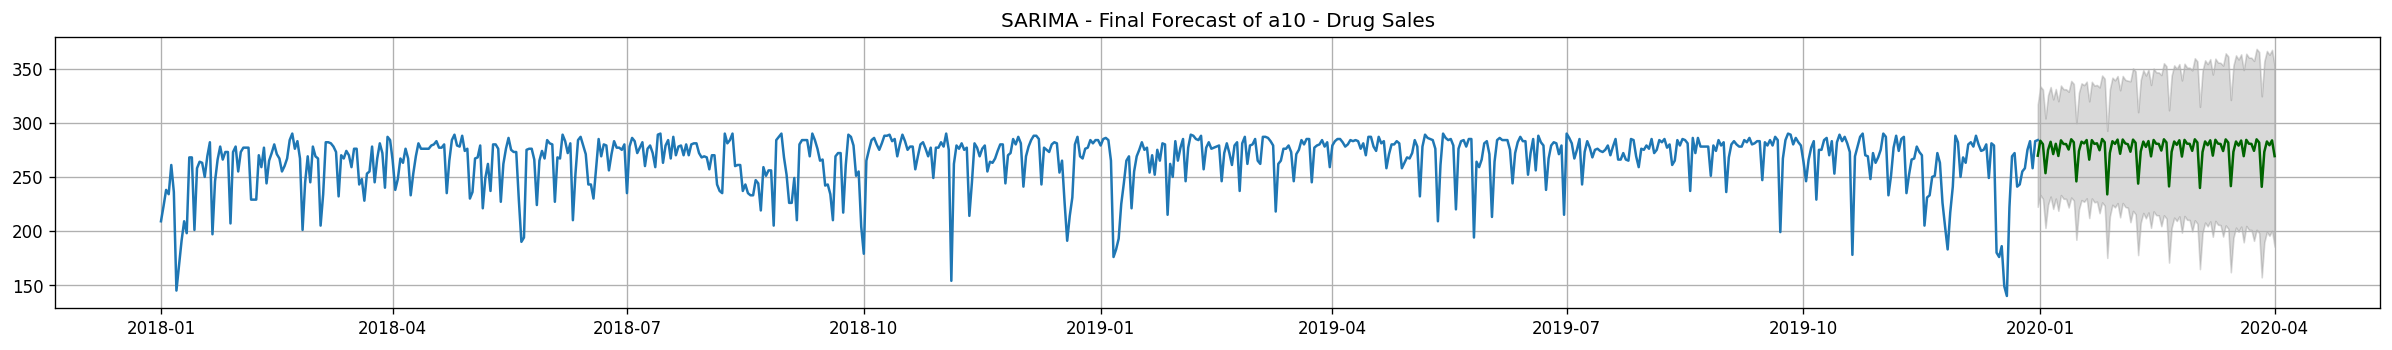

In [42]:
# Forecast
n_periods = 93
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='d')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

In [ ]:
y = df.value

## Adf Test
ndiffs(y, test='adf')  # 2

# KPSS test
ndiffs(y, test='kpss')  # 0

# PP test:
ndiffs(y, test='pp')  # 2

## TUT 2

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

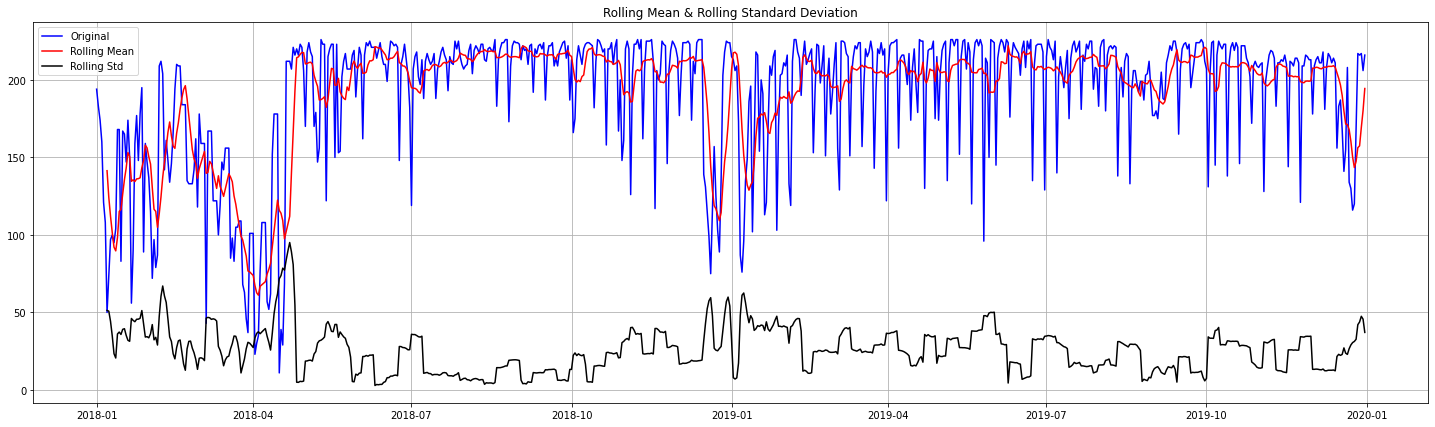

In [13]:
rolling_mean = df.rolling(window = 7).mean()
rolling_std = df.rolling(window = 7).std()
plt.figure(figsize=(25, 7))
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

In [14]:
result = adfuller(df['ROH'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.853730825188484
p-value: 0.0509991044367794
Critical Values:
	1%: -3.439606888036868
	5%: -2.865625121924057
	10%: -2.5689454046801052


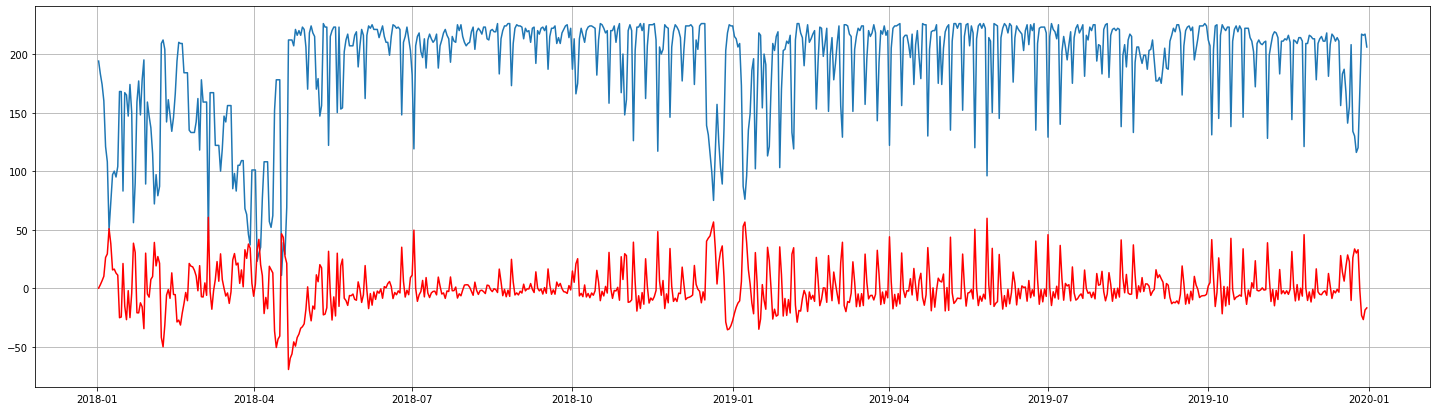

In [15]:
# decomposition = seasonal_decompose(df) 
model = ARIMA(df, order=(2,1,2))
results = model.fit(disp=-1)
plt.figure(figsize=(25, 7))
plt.plot(df.shift())
plt.plot(results.fittedvalues, color='red')

In [16]:
# predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# predictions_ARIMA_log = pd.Series(df['ROH'].iloc[0], index=df.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
# predictions_ARIMA = np.exp(predictions_ARIMA_log)
# plt.plot(df)
# plt.plot(predictions_ARIMA)

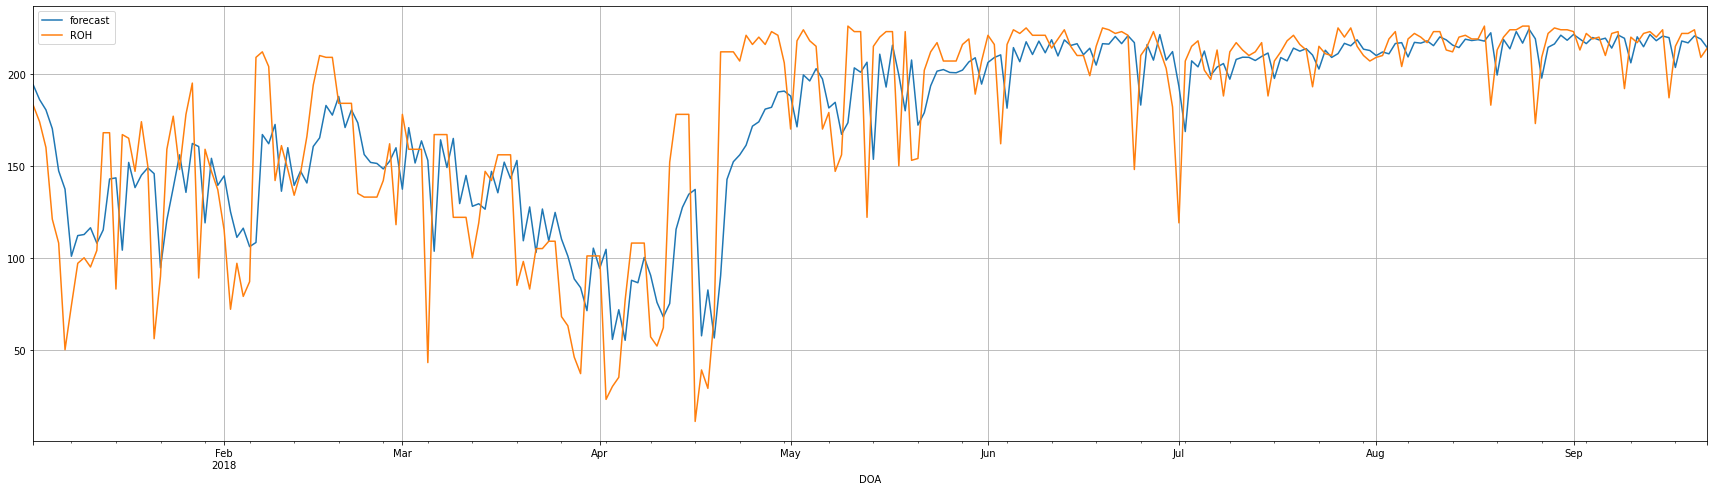

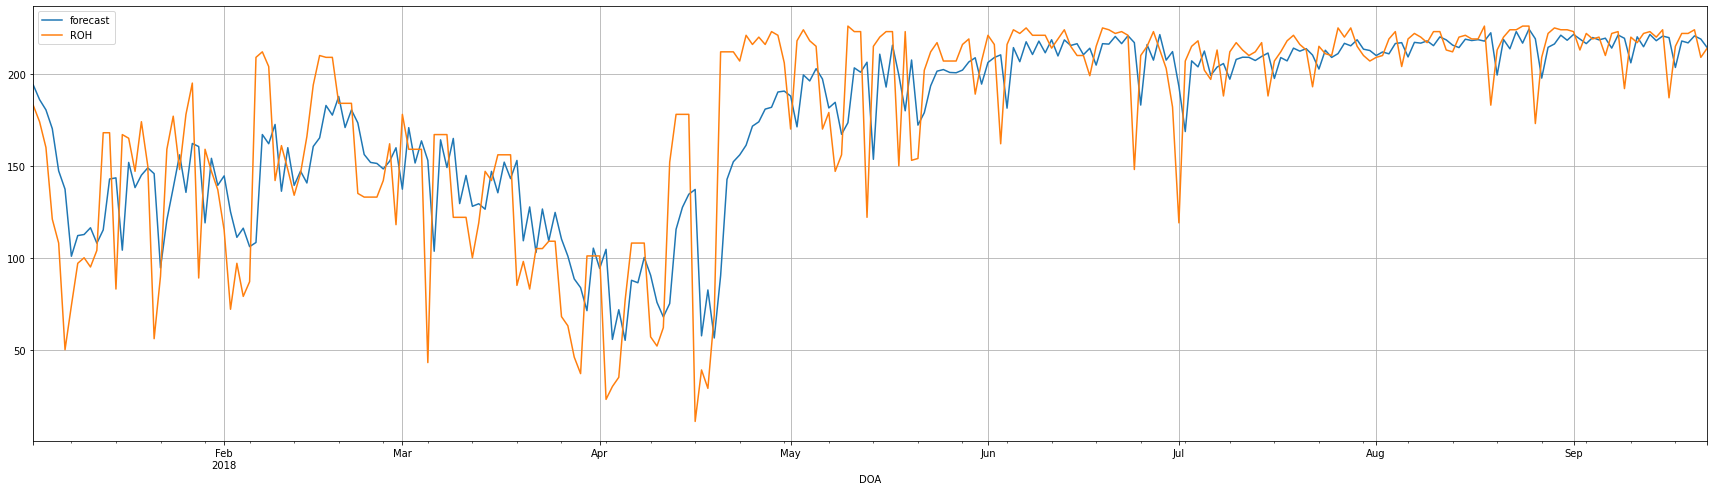

In [17]:
results.plot_predict(1,264)

Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.

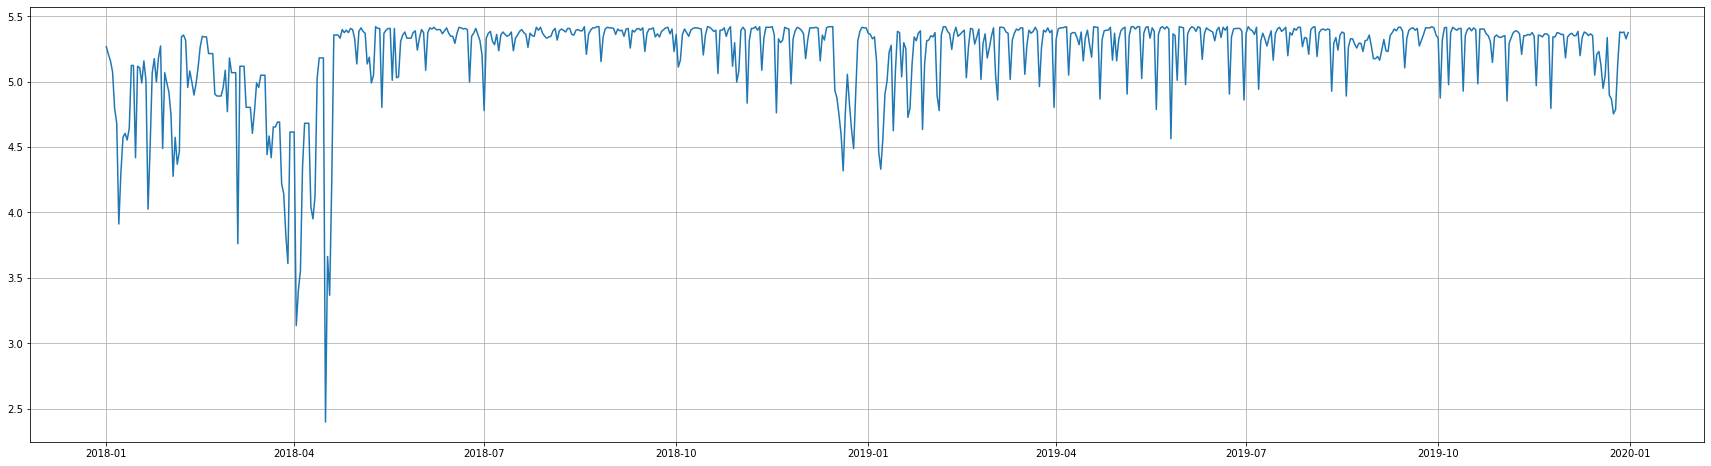

In [18]:
df_log = np.log(df)
plt.plot(df_log)

In [19]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['ROH'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

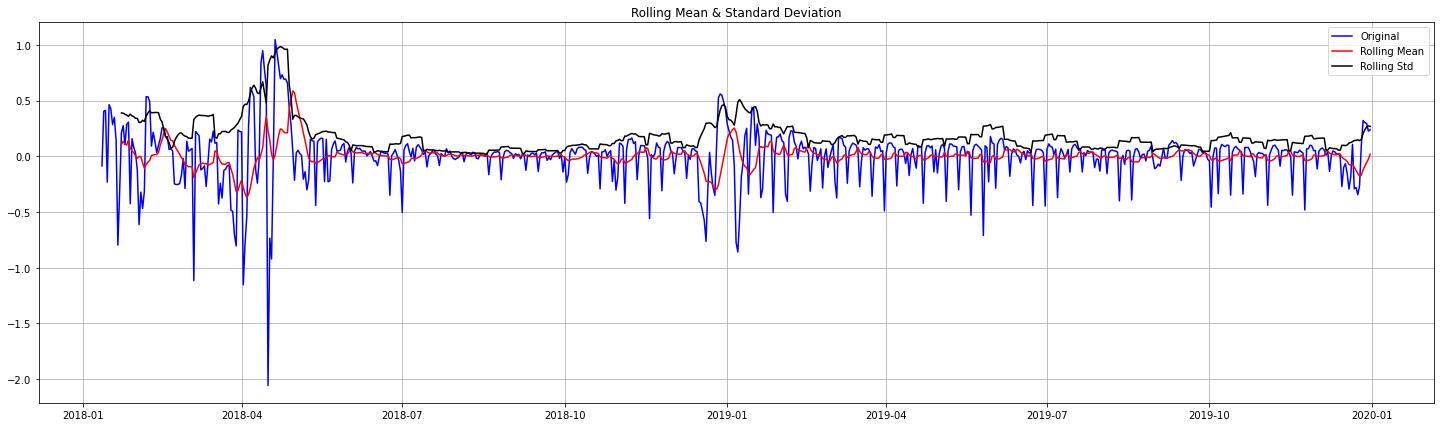

ADF Statistic: -6.768883474527773
p-value: 2.6732185593236824e-09
Critical Values:
	1%: -3.4397263458688045
	5%: -2.8656777575510204
	10%: -2.5689734469387755


In [20]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
plt.figure(figsize=(25, 7))
get_stationarity(df_log_minus_mean)

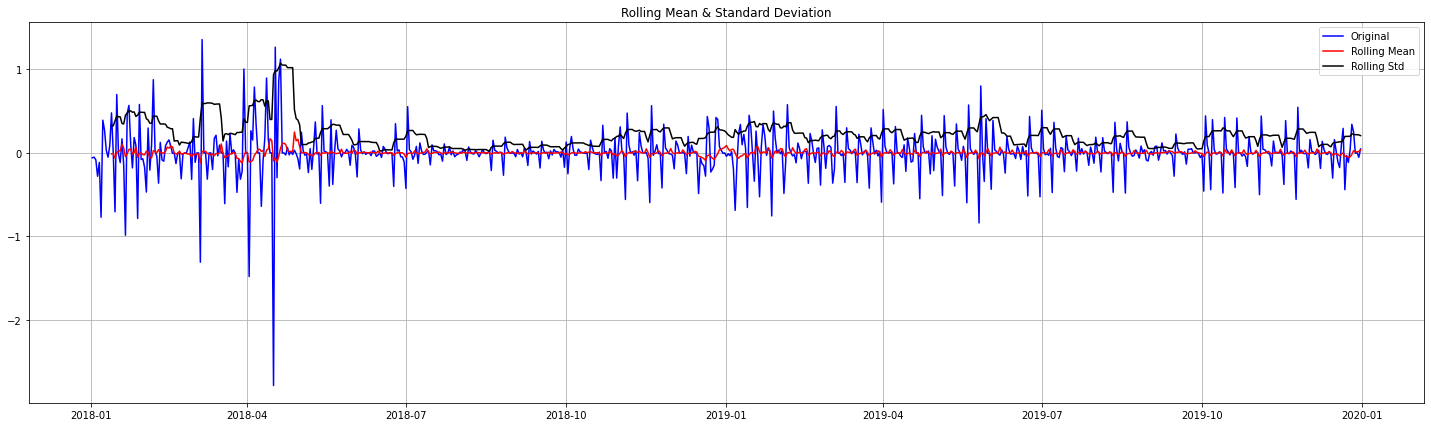

ADF Statistic: -7.479664324574609
p-value: 4.8095724785439115e-11
Critical Values:
	1%: -3.439620010600208
	5%: -2.8656309041017756
	10%: -2.5689484851894413


In [21]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
plt.figure(figsize=(25, 7))
get_stationarity(df_log_shift)

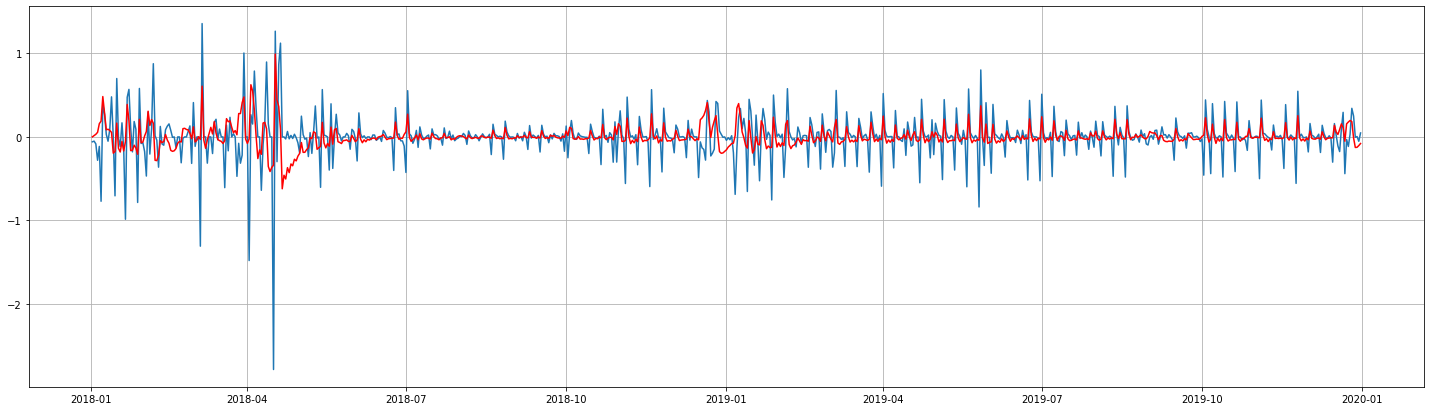

In [22]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.figure(figsize=(25, 7))
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

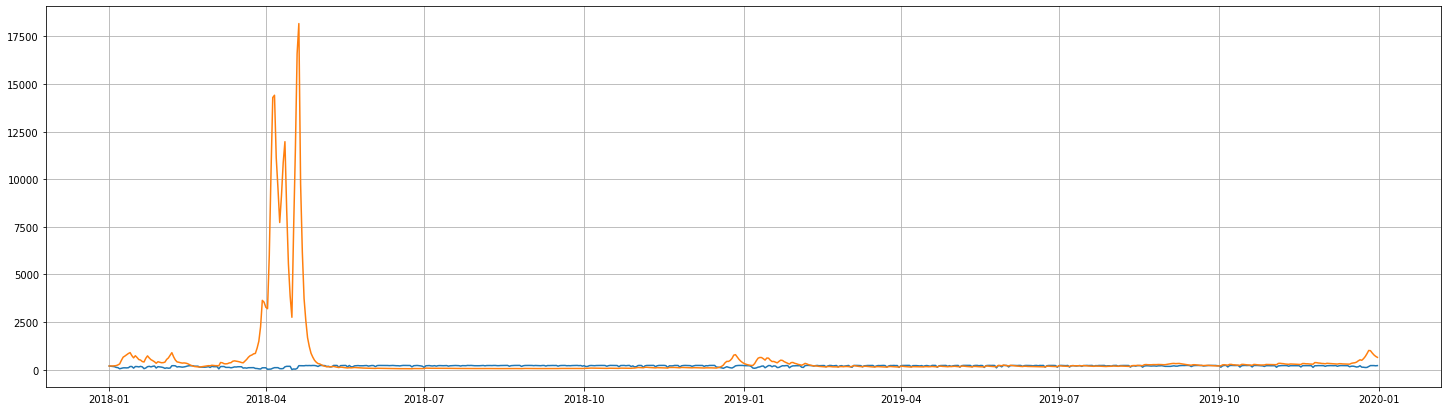

In [23]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['ROH'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(25, 7))
plt.plot(df)
plt.plot(predictions_ARIMA)

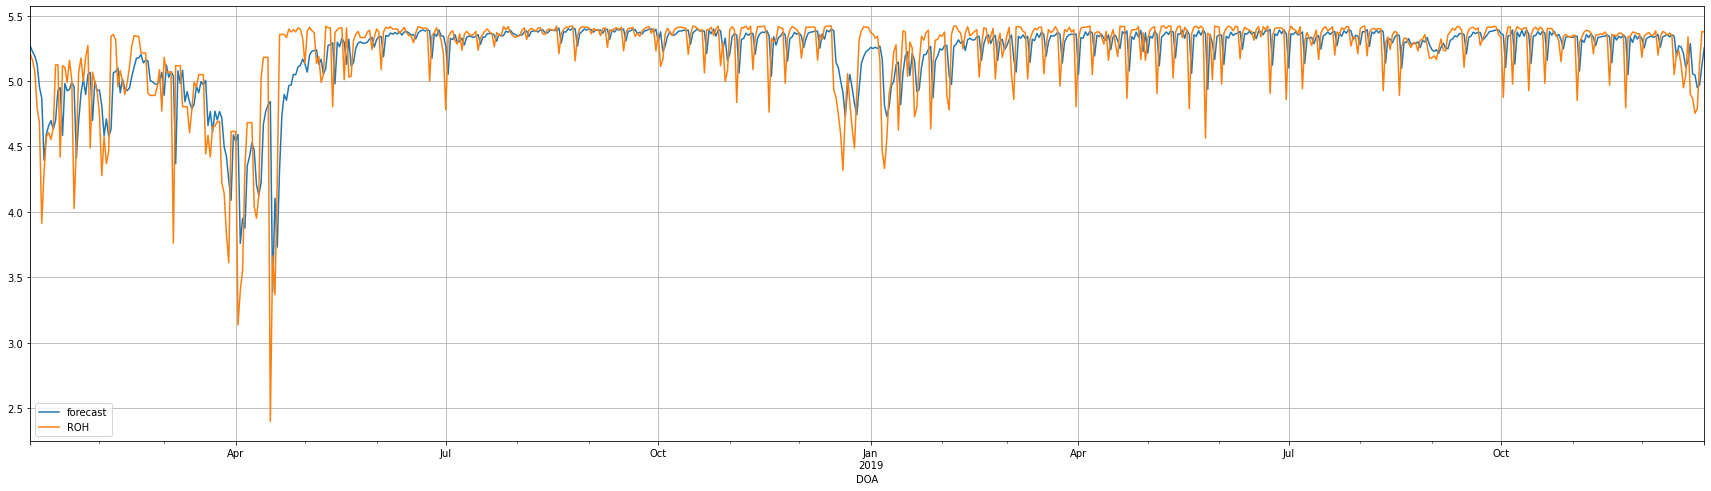

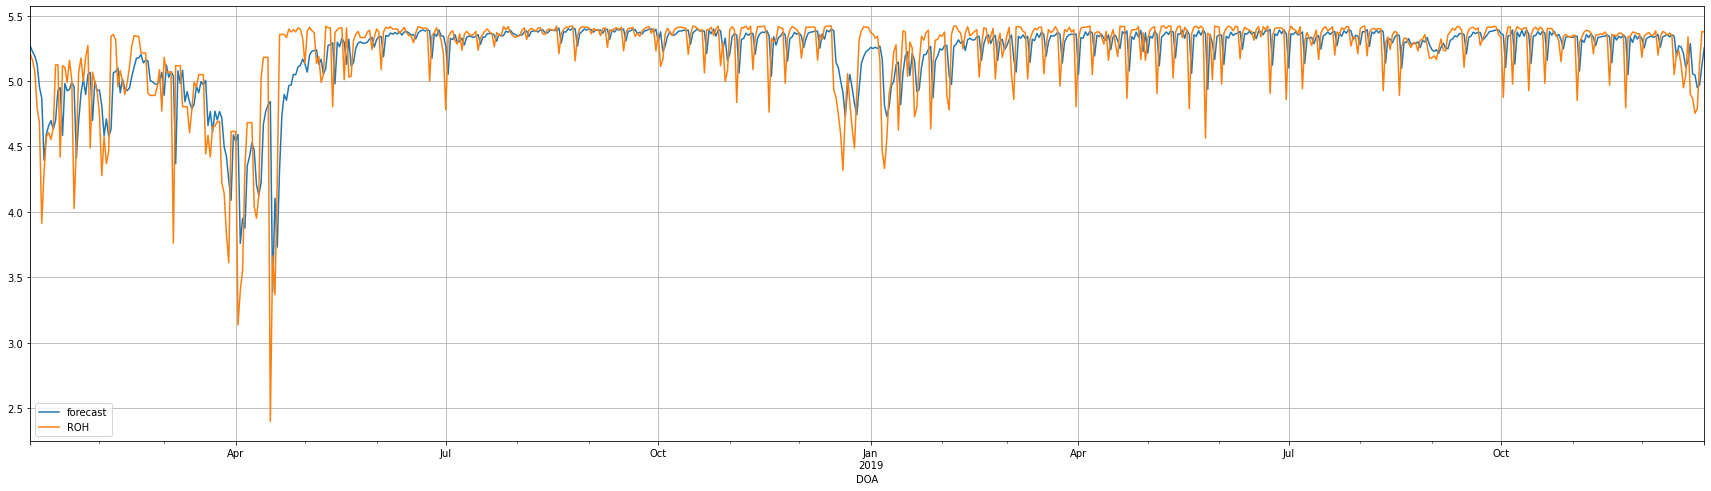

In [24]:
results.plot_predict(1,726)

In [25]:
results.

SyntaxError: invalid syntax (<ipython-input-25-91f4f5fd1e4b>, line 1)